In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd

original_path = "/content/drive/MyDrive/Kindey Stone Dataset/Original"
augmented_path = "/content/drive/MyDrive/Kindey Stone Dataset/Augmented"

image_paths = []
labels = []

def load_images(folder_path):
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(label_path, img_file))
                    labels.append(label)

# Load original + augmented
load_images(original_path)
load_images(augmented_path)

df = pd.DataFrame({"image_path": image_paths, "label": labels})
df.head()


,image_path,label
0,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
1,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
2,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
3,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
4,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone


In [4]:
df.tail()

,image_path,label
38816,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38817,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38818,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38819,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38820,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone


In [5]:
df.shape


(38821, 2)

In [6]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isnull().sum()

,0
image_path,0
label,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38821 entries, 0 to 38820
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  38821 non-null  object
 1   label       38821 non-null  object
dtypes: object(2)
memory usage: 606.7+ KB


In [10]:
df['label'].unique()

array(['Stone', 'Non-Stone'], dtype=object)

In [11]:
df['label'].value_counts()

,count
label,
Non-Stone,21027
Stone,17794


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipython-input-27832972.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


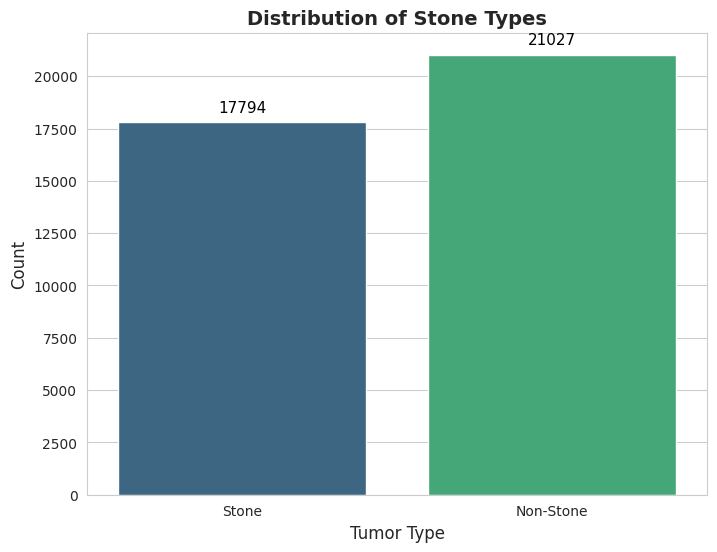

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)
ax.set_title("Distribution of Stone Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
for p in ax.patches:
 ax.annotate(f'{int(p.get_height())}',
 (p.get_x() + p.get_width() / 2., p.get_height()),
 ha='center', va='bottom', fontsize=11, color='black',
 xytext=(0, 5), textcoords='offset points')
plt.show()


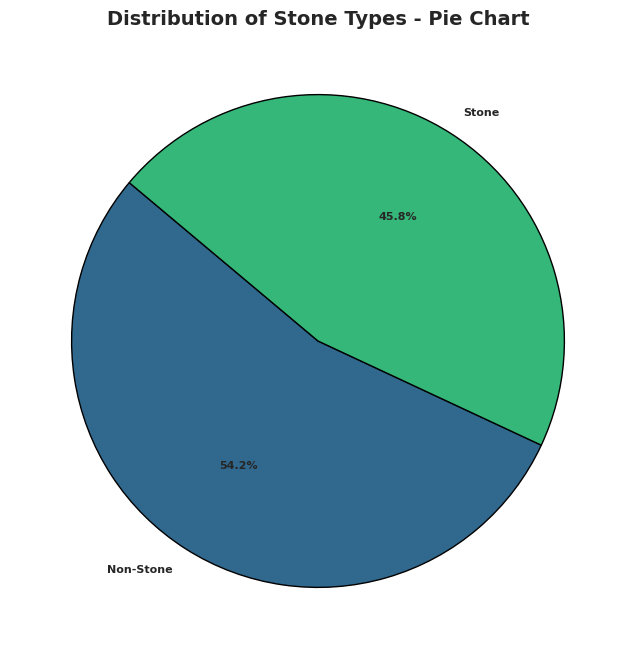

In [14]:
label_counts = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("viridis", len(label_counts))
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
 startangle=140, colors=colors, textprops={'fontsize': 8, 'weight':
'bold'},
 wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax.set_title("Distribution of Stone Types - Pie Chart", fontsize=14,
fontweight='bold')
plt.show()

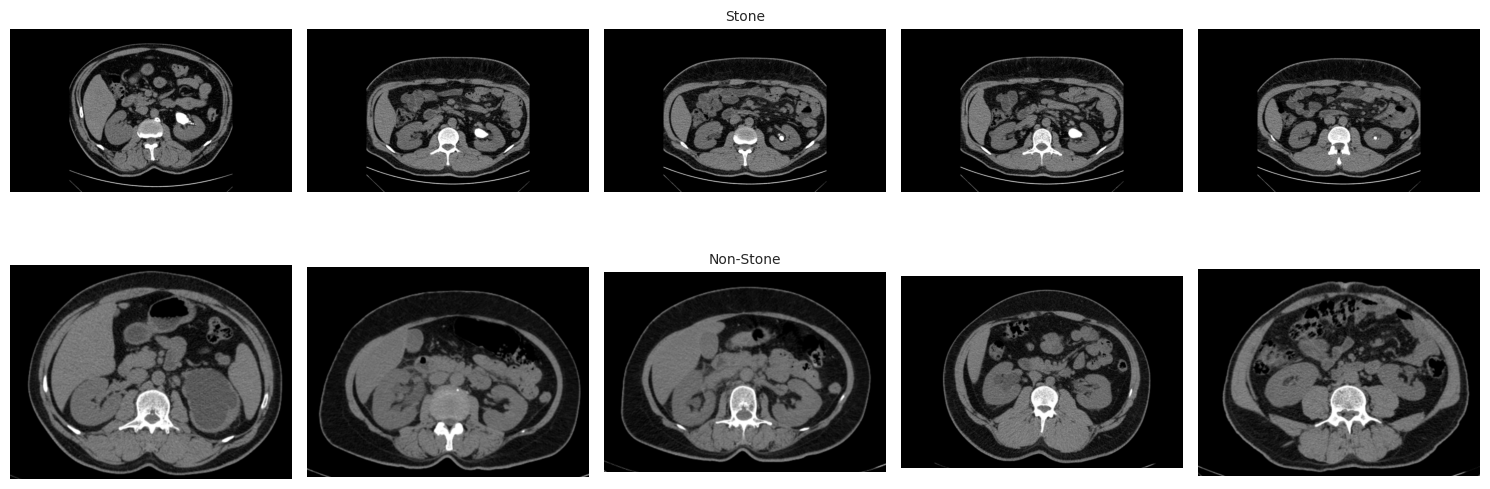

In [15]:
from PIL import Image
num_images = 5
unique_labels = df['label'].unique()
plt.figure(figsize=(15, len(unique_labels) * 3))
for row_idx, label in enumerate(unique_labels):

  label_images = df[df['label'] ==
  label].head(num_images)['image_path'].tolist()

  for col_idx, img_path in enumerate(label_images):
    plt_idx = row_idx * num_images + col_idx + 1
    plt.subplot(len(unique_labels), num_images, plt_idx)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    if col_idx == 2:
      plt.title(label, fontsize=10)
plt.tight_layout()
plt.show()

In [16]:
df

,image_path,label
0,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
1,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
2,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
3,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
4,/content/drive/MyDrive/Kindey Stone Dataset/Or...,Stone
...,...,...
38816,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38817,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38818,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone
38819,/content/drive/MyDrive/Kindey Stone Dataset/Au...,Non-Stone


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings

In [18]:
warnings.filterwarnings("ignore")
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'],
random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5,
stratify=temp_df['label'], random_state=42)
print("\n--- Data Split Validation ---")
print("Test Set Label Distribution:")
print(test_df['label'].value_counts())
print("-----------------------------\n")



--- Data Split Validation ---
Test Set Label Distribution:
label
Non-Stone    2103
Stone        1780
Name: count, dtype: int64
-----------------------------



In [21]:
class KidneyDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.df = dataframe.reset_index(drop=True)
    self.transform = transform or transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,
    0.224, 0.225])
    ])

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img = Image.open(row['image_path']).convert('RGB')
    if self.transform:
      img = self.transform(img)

    true_label_string = row['label']
    if true_label_string == 'Stone':
      label = 1
    elif true_label_string == 'Non-Stone':
      label = 0
    else:
      label = 0

    return img, label
batch_size = 32
train_loader = DataLoader(KidneyDataset(train_df), batch_size=batch_size,
shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(KidneyDataset(val_df), batch_size=batch_size,
shuffle=False, num_workers=4)
test_loader = DataLoader(KidneyDataset(test_df), batch_size=batch_size,
shuffle=False, num_workers=4)

In [22]:
class DeepSurprisePredictor(nn.Module):
 def __init__(self, dim=512):
  super().__init__()
  self.net = nn.Sequential(
  nn.Linear(dim, dim*2), nn.GELU(),
  nn.Linear(dim*2, dim*2), nn.GELU(),
  nn.Linear(dim*2, dim)
  )
  self.register_buffer('m1', torch.zeros(dim))
  self.register_buffer('m2', torch.zeros(dim))
  self.alpha = 0.99
 def forward(self, h):
  batch_mean = h.mean(dim=0)
  self.m1 = self.alpha * self.m1 + (1 - self.alpha) * batch_mean
  self.m2 = self.alpha * self.m2 + (1 - self.alpha) * self.m1
  return self.net(self.m2).expand(h.size(0), -1)


In [25]:
class HOPENestedClassifier(nn.Module):
    def __init__(self, num_classes=2, dim=512):
        super().__init__()

        # Backbone
        backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.dim = dim

        # Fast weights
        self.W_fast = nn.Parameter(torch.randn(dim, dim) * 0.02)

        # Surprise predictor
        self.surprise_net = DeepSurprisePredictor(dim)

        # Slow weights
        self.slow_level1 = nn.Linear(dim, dim)
        self.slow_level2 = nn.Linear(dim, dim)

        # Training step counter
        self.register_buffer('step', torch.tensor(0))

        # Final classifier
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        b = x.size(0)
        self.step += 1

        # Backbone feature extraction
        f = self.backbone(x)
        h = self.pool(f).flatten(1)
        h_norm = F.normalize(h, dim=-1)

        # Surprise unit output
        u_t = self.surprise_net(h)

        # Outer product terms
        h_outer = torch.bmm(h_norm.unsqueeze(2), h_norm.unsqueeze(1))
        u_outer = torch.bmm(u_t.unsqueeze(2), h_norm.unsqueeze(1))

        # Fast weight update
        delta_W_batched = -u_outer + torch.bmm(
            self.W_fast.expand(b, -1, -1),
            -h_outer
        )
        delta_W = delta_W_batched.mean(0)

        # Apply fast weight update
        with torch.no_grad():
            self.W_fast.add_(delta_W * 0.1)

        # Apply fast weights
        h_fast = torch.matmul(h_norm, self.W_fast)
        h_slow = h_fast

        # Slow weights update (nested learning)
        if self.training:
            if self.step % 4 == 0:
                h_slow = h_slow + self.slow_level1(h_slow)
            if self.step % 64 == 0:
                h_slow = h_slow + self.slow_level2(h_slow)
        else:
            # During eval, always apply both
            h_slow = h_slow + self.slow_level1(h_slow)
            h_slow = h_slow + self.slow_level2(h_slow)

        # Final classification
        logits = self.classifier(h_slow)
        return logits


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HOPENestedClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [28]:
patience = 5
epochs = 10
min_delta = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
print(f"Device: {device} | Params: {sum(p.numel() for p in
model.parameters()):,}")
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_acc = 0.0


Device: cuda | Params: 14,064,706


In [29]:
for epoch in range(epochs):

    if early_stop:
        print("\nStopping early due to non-improving validation loss.")
        break

    model.train()
    train_loss, correct, total = 0, 0, 0

    # Training loop
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        if i % 30 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {i} | Loss: {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            val_loss += criterion(logits, labels).item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    current_val_loss = val_loss / len(val_loader)
    train_acc = correct / total
    val_acc = val_correct / len(val_loader.dataset)

    # LR scheduler
    scheduler.step(current_val_loss)

    # Store history
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_acc"].append(train_acc)
    history["val_loss"].append(current_val_loss)
    history["val_acc"].append(val_acc)

    # Print metrics
    print(f"\nEPOCH {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss:   {current_val_loss:.4f} | Acc: {val_acc:.4f}")

    # Early stopping logic
    if current_val_loss < best_val_loss - min_delta:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_acc = val_acc
        torch.save(model.state_dict(), "best_hope_kidney_final.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True


# Load best saved model
try:
    model.load_state_dict(torch.load("best_hope_kidney_final.pth"))
except FileNotFoundError:
    print("Warning: Best model file not found. Using the weights from the last epoch.")


# Testing
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)

        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


Epoch 1/10 | Batch 0 | Loss: 0.6965
Epoch 1/10 | Batch 30 | Loss: 0.2007
Epoch 1/10 | Batch 60 | Loss: 0.1159
Epoch 1/10 | Batch 90 | Loss: 0.2436
Epoch 1/10 | Batch 120 | Loss: 0.1569
Epoch 1/10 | Batch 150 | Loss: 0.1018
Epoch 1/10 | Batch 180 | Loss: 0.1888
Epoch 1/10 | Batch 210 | Loss: 0.1274
Epoch 1/10 | Batch 240 | Loss: 0.1097
Epoch 1/10 | Batch 270 | Loss: 0.0344
Epoch 1/10 | Batch 300 | Loss: 0.0405
Epoch 1/10 | Batch 330 | Loss: 0.0423
Epoch 1/10 | Batch 360 | Loss: 0.0619
Epoch 1/10 | Batch 390 | Loss: 0.1208
Epoch 1/10 | Batch 420 | Loss: 0.0125
Epoch 1/10 | Batch 450 | Loss: 0.0400
Epoch 1/10 | Batch 480 | Loss: 0.0222
Epoch 1/10 | Batch 510 | Loss: 0.1758
Epoch 1/10 | Batch 540 | Loss: 0.1277
Epoch 1/10 | Batch 570 | Loss: 0.0074
Epoch 1/10 | Batch 600 | Loss: 0.0234
Epoch 1/10 | Batch 630 | Loss: 0.1460
Epoch 1/10 | Batch 660 | Loss: 0.0106
Epoch 1/10 | Batch 690 | Loss: 0.0342
Epoch 1/10 | Batch 720 | Loss: 0.0132
Epoch 1/10 | Batch 750 | Loss: 0.0097
Epoch 1/10 | Batc


FINAL TEST ACCURACY: 98.94%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Non-Stone       0.99      0.99      0.99      2103
       Stone       0.99      0.99      0.99      1780

    accuracy                           0.99      3883
   macro avg       0.99      0.99      0.99      3883
weighted avg       0.99      0.99      0.99      3883



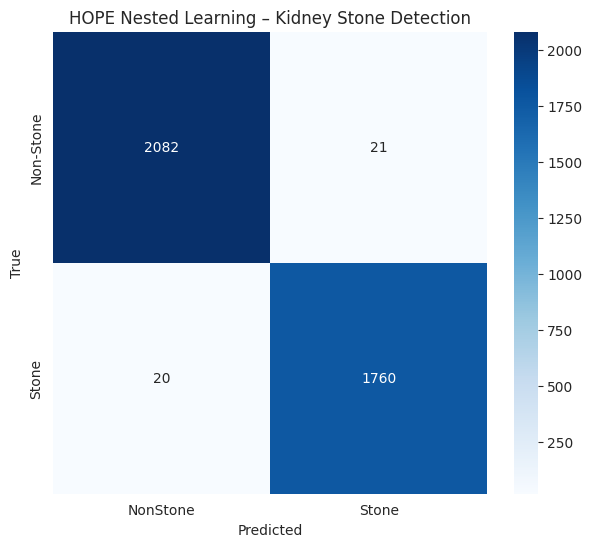

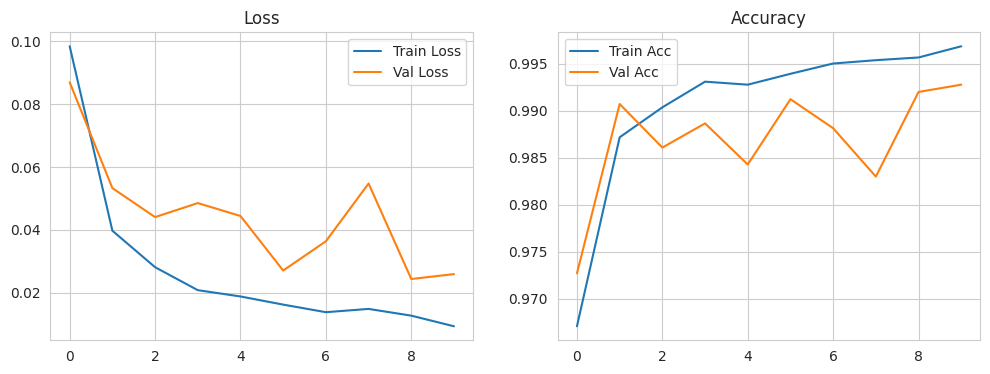


Nested Learning (HOPE) successfully trained!
Your model now rewrites its own memory like a living brain.


In [30]:
acc = accuracy_score(all_labels, all_preds)
print(f"\nFINAL TEST ACCURACY: {acc*100:.2f}%")
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, labels=[0, 1],
target_names=["Non-Stone", "Stone"], zero_division=0))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NonStone','Stone'], yticklabels=['Non-Stone','Stone'])
plt.title('HOPE Nested Learning – Kidney Stone Detection')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()
print(f"\nNested Learning (HOPE) successfully trained!")
print("Your model now rewrites its own memory like a living brain.")
